# AI 201 Mini Project
## Coffee Match: Leveraging Machine Learning for Coffee Bean Recommendations Using Taste Profiles
### Recommender Model Implementation

Submitted by: 
Jan Lendl R. Uy, 2019-00312

In [1]:
%pip install scikit-learn numpy pandas optuna tqdm plotly

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm as notebook_tqdm
import optuna
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

/Users/lendluy/Documents/MEngg AI/AI 201 2nd Take/ai201/mini_project/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load the cleaned dataset

In [3]:
# Define the same column names from the EDA notebook
feature_cols = ['aroma', 'flavor', 'aftertaste', 'acidity', 'body', 
                'balance', 'uniformity', 'clean_cup', 'sweetness']
label_cols = ['country_of_origin', 'variety', 'processing_method']

### Cleaned dataset

In [4]:
# Read the cleaned dataset
loaded_df = pd.read_csv('datasets/preprocessed_coffee_data.csv')

# Split into X and y using these column names
X = loaded_df[feature_cols].to_numpy()
y = loaded_df[label_cols].to_numpy()

### Cleaned dataset with resampling

In [5]:
smote_df = pd.read_csv('datasets/preprocessed_coffee_data_resampled.csv')

# Split into X and y using these column names
X_smote = smote_df[feature_cols].to_numpy()
y_smote = smote_df[label_cols].to_numpy()

## Split the dataset into training and test sets

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

In [7]:
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(
    X_smote, y_smote, test_size=0.2, random_state=0
)

## Recommender Models
- Truncated SVD
- Non-negative Matrix Factorization

### Helper function for inference

In [8]:
# Get predictions
def get_top_k_predictions(train_transformed, test_transformed, y_train, k=5):
    similarities = cosine_similarity(test_transformed, train_transformed)
    predictions = []
    for i in range(len(test_transformed)):
        similar_indices = similarities[i].argsort()[::-1][:k]
        pred_countries = y_train[similar_indices, 0]
        pred_varieties = y_train[similar_indices, 1]
        pred_processes = y_train[similar_indices, 2]
        predictions.append((pred_countries, pred_varieties, pred_processes))
    return predictions

## Evaluation metrics
- Mean Average Precision (mAP)
- Precision@K

In [9]:
def compute_map(y_true, predictions, weights, k=5):
    """
    Compute Mean Average Precision (mAP) for multi-label recommendation tasks.
    
    Parameters:
    -----------
    y_true : array-like
        True labels for the test data (country, variety, process).
    predictions : list of tuples
        Predicted top-k values for each label (countries, varieties, processes).
    weights : dict
        Weights for each label type.
    k : int, default=5
        Number of top predictions to consider.
    
    Returns:
    --------
    float
        Mean Average Precision (mAP) score.
    """
    ap_scores = []

    for i in range(len(y_true)):
        true_country, true_variety, true_process = y_true[i]
        pred_countries, pred_varieties, pred_processes = predictions[i]

        # Track correct predictions
        correct_country = 0
        correct_variety = 0
        correct_process = 0

        # Precision at each step
        precisions = []

        for j in range(k):
            if pred_countries[j] == true_country:
                correct_country += 1
            if pred_varieties[j] == true_variety:
                correct_variety += 1
            if pred_processes[j] == true_process:
                correct_process += 1

            # Compute weighted precision at current step
            precision = (
                weights['country'] * correct_country / (j + 1) +
                weights['variety'] * correct_variety / (j + 1) +
                weights['process'] * correct_process / (j + 1)
            )
            precisions.append(precision)

        # Compute AP (Average Precision) for current sample
        if precisions:  # At least one correct prediction
            ap = sum(precisions) / len(precisions)  # Mean of precisions at all recall levels
        else:
            ap = 0  # No correct predictions

        ap_scores.append(ap)

    return np.mean(ap_scores)


def compute_precision_at_k(y_true, predictions, weights, k=5):
    """
    Calculate weighted Precision@k for multi-label predictions.
    
    Parameters:
    -----------
    y_true : array-like
        True labels for the test data (country, variety, process).
    predictions : list of tuples
        Predicted top-k values for each label (countries, varieties, processes).
    weights : dict
        Weights for each label type.
    k : int, default=5
        Number of top predictions to consider.
    
    Returns:
    --------
    float
        Weighted Precision@k score.
    """
    total_precision = 0
    
    for i in range(len(y_true)):
        true_country, true_variety, true_process = y_true[i]
        pred_countries, pred_varieties, pred_processes = predictions[i]

        correct_countries = sum(1 for c in pred_countries[:k] if c == true_country)
        correct_varieties = sum(1 for v in pred_varieties[:k] if v == true_variety)
        correct_processes = sum(1 for p in pred_processes[:k] if p == true_process)

        precision_country = correct_countries / k
        precision_variety = correct_varieties / k
        precision_process = correct_processes / k

        weighted_precision = (
            weights['country'] * precision_country +
            weights['variety'] * precision_variety +
            weights['process'] * precision_process
        )

        total_precision += weighted_precision

    return total_precision / len(y_true)

def evaluate_recommendations(y_train, y_test, predictions, k=5):
    """
    Evaluate recommender system using precomputed predictions and various metrics.
    
    Parameters:
    -----------
    y_train : array-like
        Training labels for defining weights.
    y_test : array-like
        True labels for the test data (country, variety, process).
    predictions : list of tuples
        Predicted top-k values for each label (countries, varieties, processes).
    k : int, default=5
        Number of top predictions to consider.
    
    Returns:
    --------
    dict
        Evaluation metrics including precision@k and mAP.
    """
    # Define weights
    n_countries = len(np.unique(y_train[:, 0]))
    n_varieties = len(np.unique(y_train[:, 1]))
    n_processes = len(np.unique(y_train[:, 2]))
    
    weights = {
        'country': 1 / n_countries,
        'variety': 1 / n_varieties,
        'process': 1 / n_processes
    }
    total = sum(weights.values())
    weights = {k: v / total for k, v in weights.items()}
    
    # Compute metrics
    precision_at_k = compute_precision_at_k(y_test, predictions, weights, k)
    map_score = compute_map(y_test, predictions, weights, k)
    
    return {
        f"precision@{k}": precision_at_k,
        "map": map_score
    }

### SVD Implementation

In [10]:
# Scale the data
scaler = StandardScaler()
X_train_std_scaled = scaler.fit_transform(X_train)
X_test_std_scaled = scaler.transform(X_test)

# Train SVD
svd = TruncatedSVD(n_components=3, random_state=0)
X_train_svd = svd.fit_transform(X_train_std_scaled)

# Transform test data
X_test_svd = svd.transform(X_test_std_scaled)

# Inference
svd_predictions = get_top_k_predictions(X_train_svd, X_test_svd, y_train)

# Evaluate metrics using precomputed predictions
svd_metrics = evaluate_recommendations(y_train, y_test, svd_predictions, k=5)

# Print results
print(svd_metrics)

{'precision@5': 0.3839718851695481, 'map': np.float64(0.3859831117455632)}


### NMF Implementation

In [11]:
# Train NMF
nmf = NMF(n_components=5, tol=1e-3, random_state=0)
X_train_nmf = nmf.fit_transform(X_train)

# Transform test data
X_test_nmf = nmf.transform(X_test)

# Inference
nmf_predictions = get_top_k_predictions(X_train_nmf, X_test_nmf, y_train)

# Evaluate metrics using precomputed predictions
nmf_metrics = evaluate_recommendations(y_train, y_test, nmf_predictions, k=5)

# Print results
print(nmf_metrics)

{'precision@5': 0.3664158430214969, 'map': np.float64(0.36696519519483195)}


/Users/lendluy/Documents/MEngg AI/AI 201 2nd Take/ai201/mini_project/.venv/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


## Evaluate the recommender models

In [12]:
def plot_metrics_comparison(svd_metrics, nmf_metrics):
    """
    Plot comparison of model metrics
    
    Parameters:
    -----------
    svd_metrics : dict
        Dictionary of SVD model metrics
    nmf_metrics : dict
        Dictionary of NMF model metrics
    """
    metrics = list(svd_metrics.keys())
    svd_values = list(svd_metrics.values())
    nmf_values = list(nmf_metrics.values())
    
    x = np.arange(len(metrics))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(12, 6))
    rects1 = ax.bar(x - width/2, svd_values, width, label='SVD', color='skyblue')
    rects2 = ax.bar(x + width/2, nmf_values, width, label='NMF', color='lightcoral')
    
    # Add value labels on top of bars
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.4f}',
                       xy=(rect.get_x() + rect.get_width() / 2, height),
                       xytext=(0, 3),
                       textcoords="offset points",
                       ha='center', va='bottom', rotation=0)
    
    autolabel(rects1)
    autolabel(rects2)
    
    ax.set_ylabel('Score')
    ax.set_title('Comparison of SVD and NMF Models')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()    

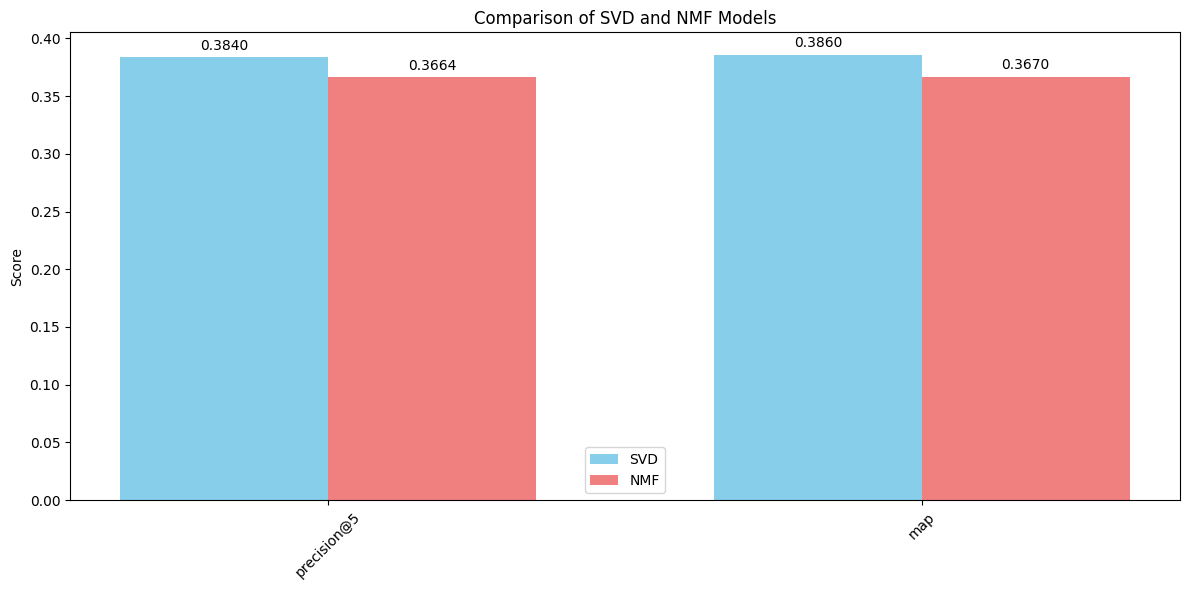

In [13]:
plot_metrics_comparison(svd_metrics, nmf_metrics)

## Perform hyperparameter optimization

### Objective Functions

In [14]:
def objective_svd(trial, X_train_scaled, y_train):
    """
    Objective function for SVD hyperparameter optimization
    """
    # Get minimum dimension
    min_dim = min(X_train_scaled.shape)
    
    # Define hyperparameters to optimize
    algorithm = trial.suggest_categorical('algorithm', ['randomized', 'arpack'])
    
    # Adjust n_components based on algorithm
    if algorithm == 'arpack':
        # For arpack: 0 < n_components < min(X.shape)
        n_components = trial.suggest_int('n_components', 2, min(min_dim - 1, 15))
    else:
        # For randomized: can use any value up to min(X.shape)
        n_components = trial.suggest_int('n_components', 2, min(min_dim, 15))
    
    tol = trial.suggest_float('tol', 1e-5, 1e-3, log=True)
    
    try:
        # Create and train model
        svd_params = {
            'n_components': n_components,
            'algorithm': algorithm,
            'tol': tol,
            'random_state': 0,
            'n_iter': 2000  # Increased to 2000 as requested
        }
            
        svd = TruncatedSVD(**svd_params)
        
        # Transform data
        X_transformed = svd.fit_transform(X_train_scaled)
        
        # Calculate performance metrics using cross-validation
        k = 5  # Number of recommendations
        cv_scores = []
        
        # Perform cross-validation manually to use our custom evaluation metric
        kf = KFold(n_splits=3, shuffle=True, random_state=0)
        
        for train_idx, val_idx in kf.split(X_transformed):
            X_train_fold, X_val_fold = X_transformed[train_idx], X_transformed[val_idx]
            y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
            
            # Calculate similarities
            similarities = cosine_similarity(X_val_fold, X_train_fold)
            
            # Calculate metrics for this fold
            fold_metrics = []
            for i in range(len(X_val_fold)):
                top_k_indices = similarities[i].argsort()[-k:][::-1]
                
                # Get actual and predicted labels
                true_labels = y_val_fold[i]
                pred_labels = y_train_fold[top_k_indices]
                
                # Calculate weighted precision@k
                correct_predictions = np.sum(pred_labels == true_labels.reshape(1, -1), axis=0)
                weighted_precision = np.mean(correct_predictions / k)
                
                fold_metrics.append(weighted_precision)
            
            cv_scores.append(np.mean(fold_metrics))
        
        return np.mean(cv_scores)
    
    except Exception as e:
        # Return a poor score if the model fails
        print(f"Trial failed with error: {str(e)}")
        return float('-inf')

In [15]:
def objective_nmf(trial, X_train, y_train):
    """
    Objective function for NMF hyperparameter optimization
    """
    # Get minimum dimension
    min_dim = min(X_train.shape)
    
    # First select solver since it affects beta_loss options
    solver = trial.suggest_categorical('solver', ['cd', 'mu'])
    
    # Define beta_loss based on solver
    if solver == 'cd':
        # CD solver only works with 'frobenius'
        beta_loss = 'frobenius'
    else:
        # MU solver works with all beta_loss options
        beta_loss = trial.suggest_categorical('beta_loss', ['frobenius', 'kullback-leibler'])
    
    # Define other hyperparameters
    n_components = trial.suggest_int('n_components', 2, min(min_dim, 15))
    init = trial.suggest_categorical('init', ['nndsvd', 'nndsvdar', 'random'])
    # tol = trial.suggest_float('tol', 1e-5, 1e-3, log=True)
    
    try:        
        # Create and train model
        nmf = NMF(
            n_components=n_components,
            init=init,
            solver=solver,
            beta_loss=beta_loss,
            # tol=tol,
            max_iter=10000,
            random_state=0
        )
        
        # Transform data
        X_transformed = nmf.fit_transform(X_train)
        
        # Calculate performance metrics using cross-validation
        k = 5  # Number of recommendations
        cv_scores = []
        
        # Perform cross-validation manually to use our custom evaluation metric
        kf = KFold(n_splits=3, shuffle=True, random_state=0)
        
        for train_idx, val_idx in kf.split(X_transformed):
            X_train_fold, X_val_fold = X_transformed[train_idx], X_transformed[val_idx]
            y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
            
            # Calculate similarities
            similarities = cosine_similarity(X_val_fold, X_train_fold)
            
            # Calculate metrics for this fold
            fold_metrics = []
            for i in range(len(X_val_fold)):
                top_k_indices = similarities[i].argsort()[-k:][::-1]
                
                # Get actual and predicted labels
                true_labels = y_val_fold[i]
                pred_labels = y_train_fold[top_k_indices]
                
                # Calculate weighted precision@k
                correct_predictions = np.sum(pred_labels == true_labels.reshape(1, -1), axis=0)
                weighted_precision = np.mean(correct_predictions / k)
                
                fold_metrics.append(weighted_precision)
            
            cv_scores.append(np.mean(fold_metrics))
        
        return np.mean(cv_scores)
    
    except Exception as e:
        # Return a poor score if the model fails
        print(f"Trial failed with error: {str(e)}")
        return float('-inf')

### Optimization Functions

In [16]:
def optimize_svd(X_train_scaled, y_train, n_trials=50):
    """
    Optimize both SVD model using Optuna
    """
    # Create studies for both models
    svd_study = optuna.create_study(direction='maximize')
    
    # Optimize SVD
    print("Optimizing SVD...")
    svd_study.optimize(
        lambda trial: objective_svd(trial, X_train_scaled, y_train),
        n_trials=n_trials
    )
    
    # Get best parameters
    best_svd_params = svd_study.best_params
    
    # Create optimized SVD model
    svd_params = {
        'n_components': best_svd_params['n_components'],
        'algorithm': best_svd_params['algorithm'],
        'tol': best_svd_params['tol'],
        'random_state': 0
    }
    if best_svd_params['algorithm'] == 'randomized':
        svd_params['n_iter'] = 1000
    best_svd = TruncatedSVD(**svd_params)
    
    return best_svd, svd_study

def optimize_nmf(X_train_scaled, y_train, n_trials=50):
    """
    Optimize NMF model using Optuna
    """
    # Create study
    nmf_study = optuna.create_study(direction='maximize')
    
    # Optimize NMF
    print("\nOptimizing NMF...")
    nmf_study.optimize(
        lambda trial: objective_nmf(trial, X_train_scaled, y_train),
        n_trials=n_trials
    )
    
    # Get best parameters
    best_nmf_params = nmf_study.best_params
        
    # Create optimized NMF model
    best_nmf = NMF(
        **best_nmf_params,
        random_state=0
    )
    
    return best_nmf, nmf_study

[I 2024-11-26 00:43:50,447] A new study created in memory with name: no-name-416cd908-4f7b-438e-b045-1acc20d00f7b


Optimizing SVD...


[I 2024-11-26 00:43:50,711] Trial 0 finished with value: 0.2787010506208214 and parameters: {'algorithm': 'randomized', 'n_components': 7, 'tol': 1.1371333909477598e-05}. Best is trial 0 with value: 0.2787010506208214.
[I 2024-11-26 00:43:50,895] Trial 1 finished with value: 0.28538681948424066 and parameters: {'algorithm': 'randomized', 'n_components': 9, 'tol': 0.0007069267681452348}. Best is trial 1 with value: 0.28538681948424066.
[I 2024-11-26 00:43:50,938] Trial 2 finished with value: 0.2785100286532951 and parameters: {'algorithm': 'arpack', 'n_components': 8, 'tol': 0.000920929059963833}. Best is trial 1 with value: 0.28538681948424066.
[I 2024-11-26 00:43:50,977] Trial 3 finished with value: 0.2711875198981217 and parameters: {'algorithm': 'arpack', 'n_components': 5, 'tol': 0.0005735810213243653}. Best is trial 1 with value: 0.28538681948424066.
[I 2024-11-26 00:43:51,160] Trial 4 finished with value: 0.27379815345431396 and parameters: {'algorithm': 'randomized', 'n_componen


Optimizing NMF...


/Users/lendluy/Documents/MEngg AI/AI 201 2nd Take/ai201/mini_project/.venv/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 10000 reached. Increase it to improve convergence.
  warnings.warn(
[I 2024-11-26 00:43:59,384] Trial 1 finished with value: 0.2725246736708055 and parameters: {'solver': 'cd', 'n_components': 9, 'init': 'nndsvdar'}. Best is trial 1 with value: 0.2725246736708055.
[I 2024-11-26 00:43:59,541] Trial 2 finished with value: 0.272906717605858 and parameters: {'solver': 'mu', 'beta_loss': 'frobenius', 'n_components': 8, 'init': 'nndsvdar'}. Best is trial 2 with value: 0.272906717605858.
[I 2024-11-26 00:43:59,660] Trial 3 finished with value: 0.2559694364851958 and parameters: {'solver': 'cd', 'n_components': 5, 'init': 'random'}. Best is trial 2 with value: 0.272906717605858.
[I 2024-11-26 00:44:00,102] Trial 4 finished with value: 0.2626552053486151 and parameters: {'solver': 'cd', 'n_components': 5, 'in

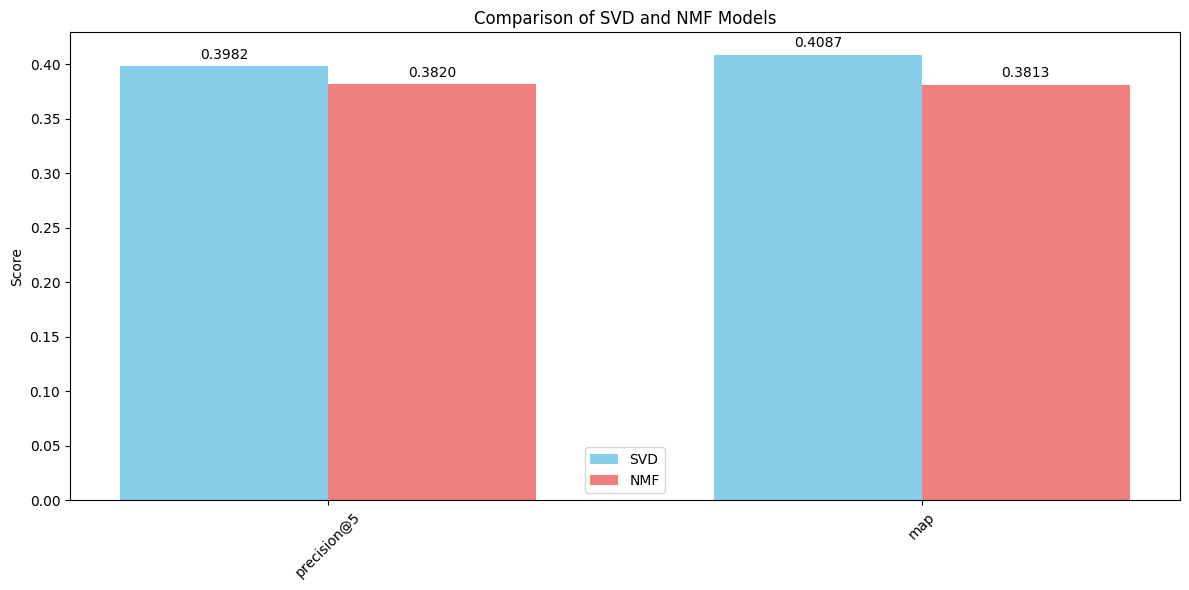

In [17]:
# Optimize models
best_svd, svd_study = optimize_svd(X_train_std_scaled, y_train, n_trials=50)
best_nmf, nmf_study = optimize_nmf(X_train, y_train, n_trials=50)

# Train models with optimal parameters
X_train_svd = best_svd.fit_transform(X_train_std_scaled)
X_train_nmf = best_nmf.fit_transform(X_train)

# Inference on test data
X_test_svd = best_svd.transform(X_test_std_scaled)
svd_predictions = get_top_k_predictions(X_train_svd, X_test_svd, y_train)
X_test_nmf = best_nmf.transform(X_test)
nmf_predictions = get_top_k_predictions(X_train_nmf, X_test_nmf, y_train)

# Evaluate optimized models
svd_metrics = evaluate_recommendations(y_train, y_test, svd_predictions, k=5)
nmf_metrics = evaluate_recommendations(y_train, y_test, nmf_predictions, k=5)

# Plot comparison
plot_metrics_comparison(svd_metrics, nmf_metrics)

## Train the recommender systems on resampled data

### SVD Implementation

In [18]:
# Scale the data
scaler = StandardScaler()
X_train_smote_std_scaled = scaler.fit_transform(X_train_smote)
X_test_smote_std_scaled = scaler.transform(X_test_smote)

# Train SVD
svd = TruncatedSVD(n_components=3, random_state=0)
X_train_smote_svd = svd.fit_transform(X_train_smote_std_scaled)

# Transform test data
X_test_smote_svd = svd.transform(X_test_smote_std_scaled)

# Inference
svd_smote_predictions = get_top_k_predictions(X_train_smote_svd, X_test_smote_svd, y_train_smote)

# Evaluate metrics using precomputed predictions
svd_smote_metrics = evaluate_recommendations(y_train_smote, y_test_smote, svd_smote_predictions, k=5)

# Print results
print(svd_smote_metrics)

{'precision@5': 0.511955295537424, 'map': np.float64(0.5429735638516499)}


### NMF Implementation

In [19]:
# Train NMF
nmf = NMF(n_components=5, tol=1e-3, random_state=0)
X_train_smote_nmf = nmf.fit_transform(X_train_smote)

# Transform test data
X_test_smote_nmf = nmf.transform(X_test_smote)

# Inference
nmf_smote_predictions = get_top_k_predictions(X_train_smote_nmf, X_test_smote_nmf, y_train_smote)

# Evaluate metrics using precomputed predictions
nmf_smote_metrics = evaluate_recommendations(y_train_smote, y_test_smote, nmf_smote_predictions, k=5)

# Print results
print(nmf_smote_metrics)

{'precision@5': 0.44683474565154563, 'map': np.float64(0.4468347456515466)}


### Evaluated the recommender systems with resample data

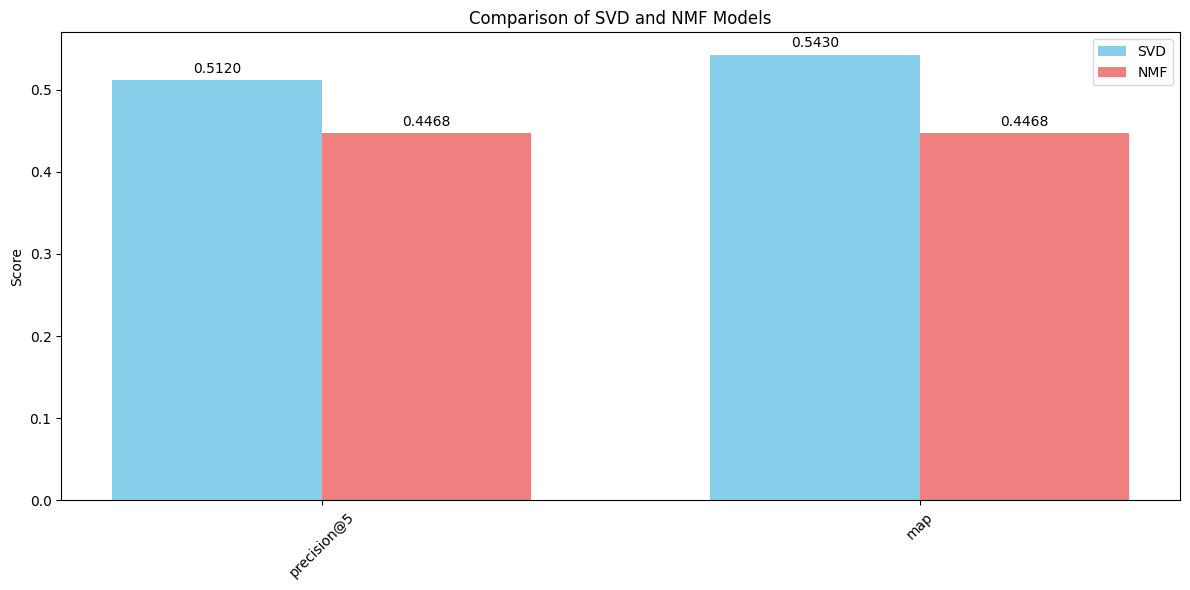

In [20]:
plot_metrics_comparison(svd_smote_metrics, nmf_smote_metrics)

### Hyperparameter optimization on retrained recommender systems

[I 2024-11-26 00:44:16,092] A new study created in memory with name: no-name-b0f0b004-3662-4bed-a951-5b306c5b39b0


Optimizing SVD...


[I 2024-11-26 00:44:16,478] Trial 0 finished with value: 0.5888584902236943 and parameters: {'algorithm': 'arpack', 'n_components': 5, 'tol': 0.000312048284788181}. Best is trial 0 with value: 0.5888584902236943.
[I 2024-11-26 00:44:16,834] Trial 1 finished with value: 0.4981667894962732 and parameters: {'algorithm': 'arpack', 'n_components': 3, 'tol': 4.331876876249401e-05}. Best is trial 0 with value: 0.5888584902236943.
[I 2024-11-26 00:44:17,184] Trial 2 finished with value: 0.5888584902236943 and parameters: {'algorithm': 'arpack', 'n_components': 5, 'tol': 6.24277503107144e-05}. Best is trial 0 with value: 0.5888584902236943.
[I 2024-11-26 00:44:17,549] Trial 3 finished with value: 0.6488284639421482 and parameters: {'algorithm': 'arpack', 'n_components': 7, 'tol': 1.7652923752713607e-05}. Best is trial 3 with value: 0.6488284639421482.
[I 2024-11-26 00:44:18,242] Trial 4 finished with value: 0.37511202383103365 and parameters: {'algorithm': 'randomized', 'n_components': 2, 'tol'


Optimizing NMF...


[I 2024-11-26 00:44:47,088] Trial 0 finished with value: 0.5998778543634149 and parameters: {'solver': 'mu', 'beta_loss': 'kullback-leibler', 'n_components': 8, 'init': 'nndsvd'}. Best is trial 0 with value: 0.5998778543634149.
[I 2024-11-26 00:44:47,509] Trial 1 finished with value: 0.3363541246903849 and parameters: {'solver': 'mu', 'beta_loss': 'frobenius', 'n_components': 6, 'init': 'random'}. Best is trial 0 with value: 0.5998778543634149.
/Users/lendluy/Documents/MEngg AI/AI 201 2nd Take/ai201/mini_project/.venv/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 10000 reached. Increase it to improve convergence.
  warnings.warn(
[I 2024-11-26 00:44:49,702] Trial 2 finished with value: 0.607253672491241 and parameters: {'solver': 'cd', 'n_components': 9, 'init': 'nndsvdar'}. Best is trial 2 with value: 0.607253672491241.
/Users/lendluy/Documents/MEngg AI/AI 201 2nd Take/ai201/mini_project/.venv/lib/python3.11/site-pack

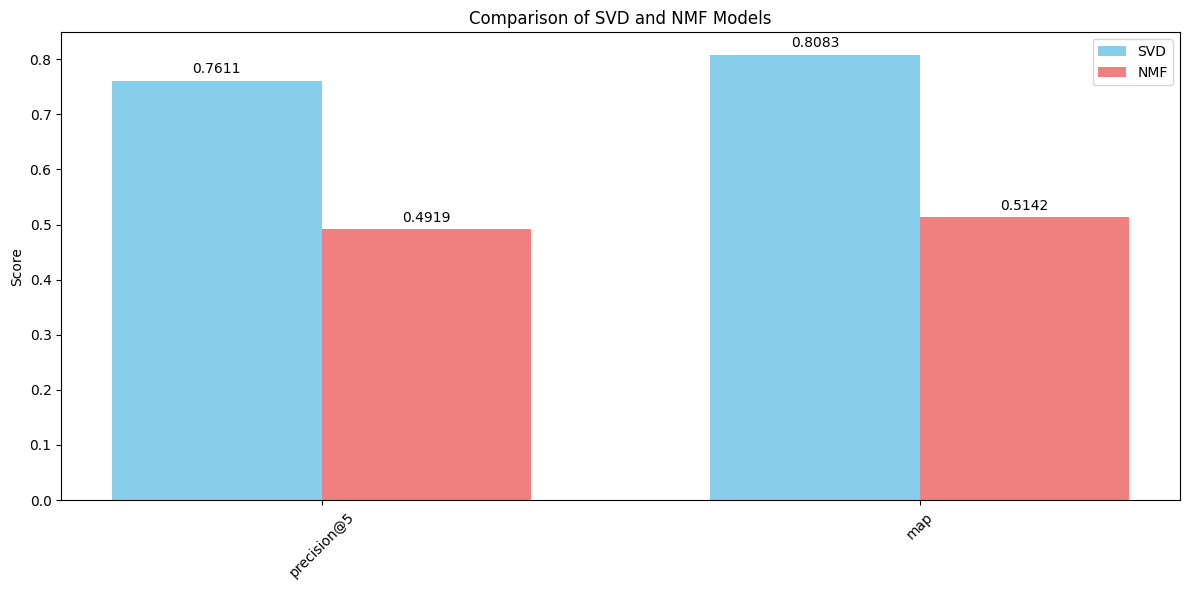

In [21]:
# Optimize models
best_svd_smote, svd_smote_study = optimize_svd(X_train_smote_std_scaled, y_train_smote, n_trials=50)
best_nmf_smote, nmf_smote_study = optimize_nmf(X_train_smote, y_train_smote, n_trials=50)

# Train models with optimal parameters
X_train_smote_svd = best_svd_smote.fit_transform(X_train_smote_std_scaled)
X_train_smote_nmf = best_nmf_smote.fit_transform(X_train_smote)

# Inference on test data
X_test_smote_svd = best_svd_smote.transform(X_test_smote_std_scaled)
svd_smote_predictions = get_top_k_predictions(X_train_smote_svd, X_test_smote_svd, y_train_smote)
X_test_smote_nmf = best_nmf_smote.transform(X_test_smote)
nmf_smote_predictions = get_top_k_predictions(X_train_smote_nmf, X_test_smote_nmf, y_train_smote)

# Evaluate optimized models
svd_smote_metrics = evaluate_recommendations(y_train_smote, y_test_smote, svd_smote_predictions, k=5)
nmf_smote_metrics = evaluate_recommendations(y_train_smote, y_test_smote, nmf_smote_predictions, k=5)

# Plot comparison
plot_metrics_comparison(svd_smote_metrics, nmf_smote_metrics)

## SVD Results Interpretation

### Singular Values

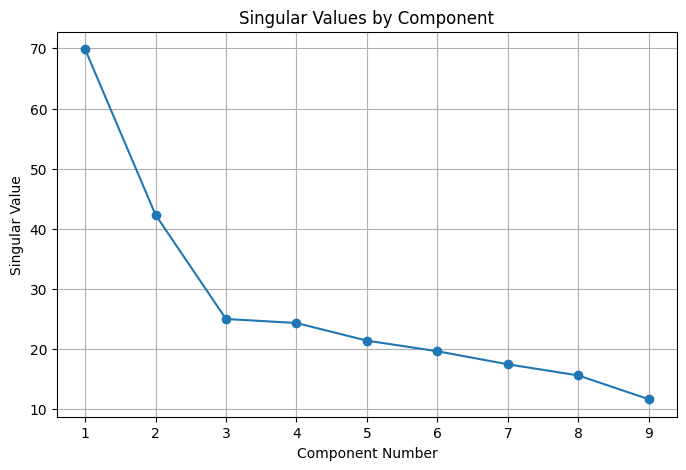

In [22]:
def plot_singular_values(svd):
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(svd.singular_values_) + 1), svd.singular_values_, marker='o')
    plt.title("Singular Values by Component")
    plt.xlabel("Component Number")
    plt.ylabel("Singular Value")
    plt.grid()
    plt.show()

plot_singular_values(best_svd)

### Explained Variance Ratio

Explained Variance Ratio by Component: [0.51794406 0.19017675 0.06641687 0.0629257  0.04868249 0.04099688
 0.03244731 0.0259365  0.01447345]
Cumulative Explained Variance: [0.51794406 0.70812082 0.77453769 0.83746338 0.88614587 0.92714275
 0.95959006 0.98552655 1.        ]


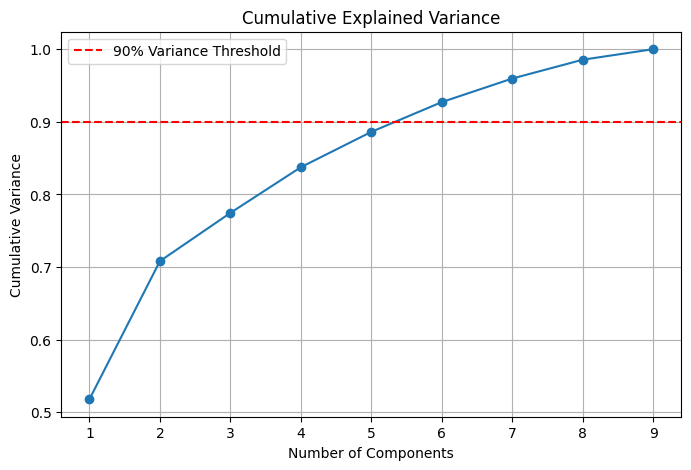

In [23]:
explained_variance = best_svd.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

print("Explained Variance Ratio by Component:", explained_variance)
print("Cumulative Explained Variance:", cumulative_variance)

# Plot cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.axhline(0.9, color='r', linestyle='--', label='90% Variance Threshold')
plt.title("Cumulative Explained Variance")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Variance")
plt.legend()
plt.grid()
plt.show()

### Latent Components

                Aroma    Flavor  Aftertaste   Acidity      Body   Balance  \
Component 1  0.379289  0.427555    0.423793  0.380453  0.372785  0.397989   
Component 2 -0.109975 -0.042328   -0.053752 -0.135040 -0.156993 -0.044588   
Component 3 -0.025502 -0.017316    0.001994  0.058190 -0.107286 -0.007519   
Component 4  0.067316  0.032443    0.049364 -0.120454 -0.156114 -0.004866   
Component 5  0.614744  0.239149    0.047542  0.117116 -0.596718 -0.413336   
Component 6 -0.488362  0.055532   -0.012728  0.815365 -0.221847 -0.165792   
Component 7 -0.204039  0.029180    0.285796 -0.145951 -0.625745  0.659896   
Component 8 -0.399315  0.434770    0.593546 -0.322858  0.057326 -0.431721   
Component 9 -0.146190  0.750933   -0.615362 -0.122679 -0.019262  0.139130   

             Sweetness  Clean Cup  Uniformity  
Component 1   0.144851   0.155956    0.079523  
Component 2   0.537369   0.547208    0.591736  
Component 3   0.803238  -0.237202   -0.531635  
Component 4  -0.176404   0.757401   -

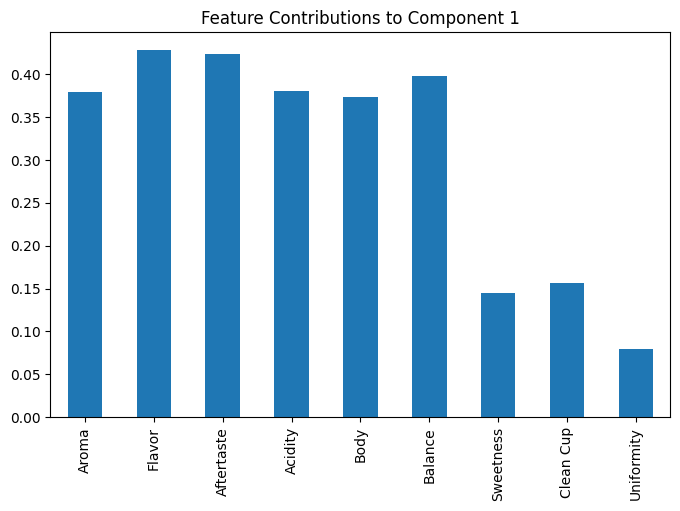

In [24]:
# Assuming feature names are in `feature_names`
feature_names = ['Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body', 'Balance', 'Sweetness', 'Clean Cup', 'Uniformity']

# Create a DataFrame of components
components_df = pd.DataFrame(best_svd.components_, columns=feature_names, index=[f'Component {i+1}' for i in range(best_svd.n_components)])

print(components_df)

# Visualize the first component
components_df.iloc[0].plot(kind='bar', figsize=(8, 5), title='Feature Contributions to Component 1')
plt.show()

### Projection of Data in the Latent Space

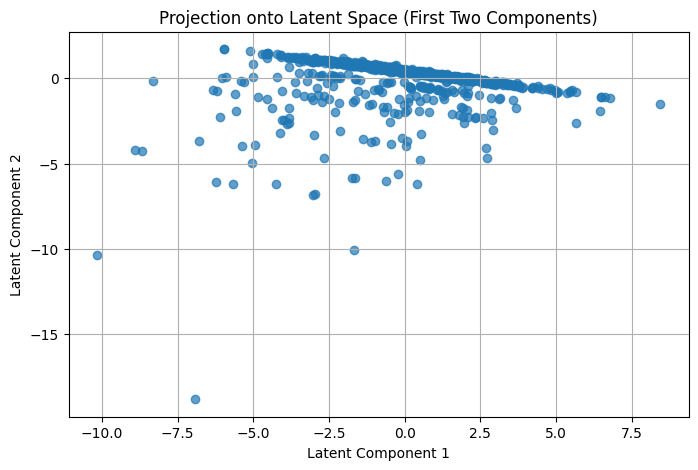

In [25]:
# Visualize the first two latent components
plt.figure(figsize=(8, 5))
plt.scatter(X_train_svd[:, 0], X_train_svd[:, 1], alpha=0.7)
plt.title("Projection onto Latent Space (First Two Components)")
plt.xlabel("Latent Component 1")
plt.ylabel("Latent Component 2")
plt.grid()
plt.show()

In [26]:
from sklearn.metrics import mean_squared_error

# Reconstruct the data
X_train_reconstructed = best_svd.inverse_transform(X_train_svd)

# Compute reconstruction error
mse = mean_squared_error(X_train, X_train_reconstructed)
print(f"Reconstruction MSE: {mse}")

Reconstruction MSE: 70.43823410919583


## NMF Results Interpretation

In [38]:
W = X_train_nmf
H = best_nmf.components_

### Heatmap of beans H

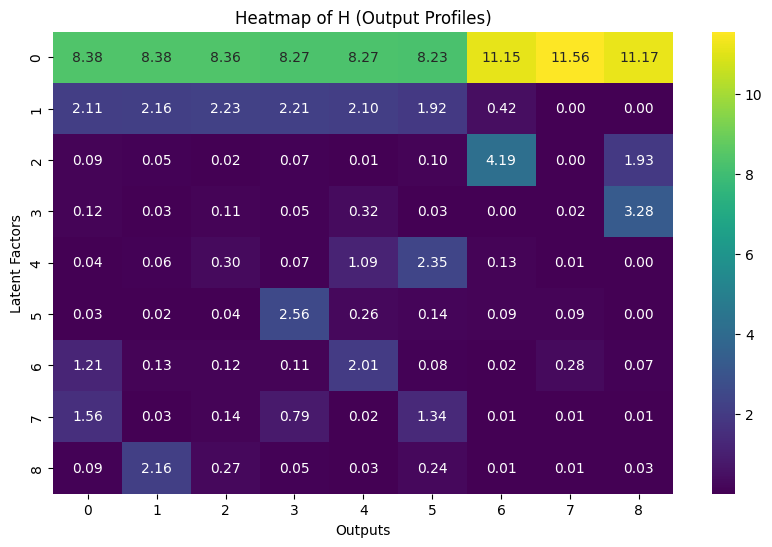

In [39]:
import seaborn as sns

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(H, annot=True, cmap="viridis", fmt=".2f")
plt.title("Heatmap of H (Output Profiles)")
plt.xlabel("Outputs")
plt.ylabel("Latent Factors")
plt.show()

### Analyze User/Taste Profiles in W

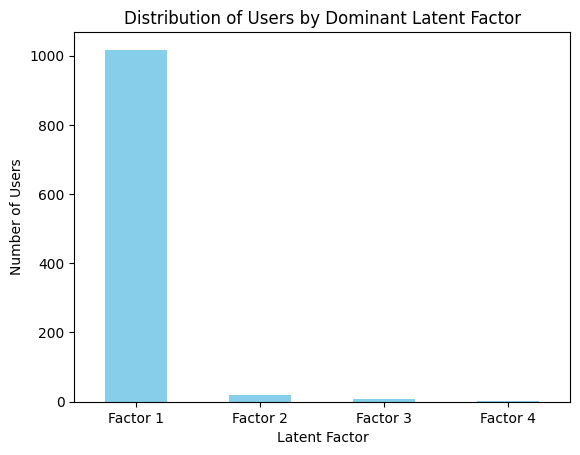

In [40]:
# Find dominant factor for each user
dominant_factors = np.argmax(W, axis=1)

# Count users per dominant factor
factor_counts = pd.Series(dominant_factors).value_counts()

# Plot distribution of users per factor
factor_counts.plot(kind="bar", color="skyblue")
plt.title("Distribution of Users by Dominant Latent Factor")
plt.xlabel("Latent Factor")
plt.ylabel("Number of Users")
plt.xticks(ticks=range(len(factor_counts)), labels=[f"Factor {i+1}" for i in range(len(factor_counts))], rotation=0)
plt.show()